# WTTE-RNN in pytorch ( standalone )
A template to use with data of varying shape (but fixed sequence length for now).

Like the original keras version this notebook is meant to be explicit and has no dependencies with the rest of the repo.  PRs are welcome from pytorch veterans.

In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F

### Objective Functions in PyTorch

In [20]:
def weibull_loss_discrete(y_true, y_pred):
    y = y_true[..., 0]
    u = y_true[..., 1]

    a = y_pred[..., 0]
    b = y_pred[..., 1]
    
    hazard0 = torch.pow((y + 1e-35) / a, b)
    hazard1 = torch.pow((y + 1.0) / a, b)

    loglikelihoods = u * (torch.log(torch.exp(hazard1 - hazard0) - 1.0)) - hazard1
    loss = -1 * torch.mean(loglikelihoods)
    return loss

def output_lambda(x, init_alpha=1.0, max_beta_value=5.0, max_alpha_value=None):
    a = x[..., 0]
    b = x[..., 1]
    
    # TODO: does pytorch have a canonical epsilon?
    epsilon = 1e-35
    
    # Implicitly initialize alpha:
    if max_alpha_value is None:
        a = torch.exp(a) * init_alpha
    else:
        a = init_alpha * torch.clamp(a, min=epsilon,
                                     max=max_alpha_value)

    m = max_beta_value
    if m > 1.05:  # some value >>1.0
        # shift to start around 1.0
        # assuming input is around 0.0
        _shift = np.log(m - 1.0)

        b = F.sigmoid(b - _shift)
    else:
        b = F.sigmoid(b)

    # Clipped sigmoid : has zero gradient at 0,1
    # Reduces the small tendency of instability after long training
    # by zeroing gradient.
    b = m * torch.clamp(b, min=epsilon, max=1. - epsilon)

    x = torch.stack([a, b], dim=len(a.shape))

    return x

## Generate evenly spaced sequences with noisy measurements

In [21]:
def get_data(n_timesteps, every_nth,n_repeats,noise_level,n_features,use_censored = True):
    def get_equal_spaced(n, every_nth):
        # create some simple data of evenly spaced events recurring every_nth step
        # Each is on (time,batch)-format
        events = np.array([np.array(range(n)) for _ in range(every_nth)])
        events = events + np.array(range(every_nth)).reshape(every_nth, 1) + 1

        tte_actual = every_nth - 1 - events % every_nth

        was_event = (events % every_nth == 0) * 1.0
        was_event[:, 0] = 0.0

        events = tte_actual == 0

        is_censored = (events[:, ::-1].cumsum(1)[:, ::-1] == 0) * 1
        tte_censored = is_censored[:, ::-1].cumsum(1)[:, ::-1] * is_censored
        tte_censored = tte_censored + (1 - is_censored) * tte_actual

        events = np.copy(events.T * 1.0)
        tte_actual = np.copy(tte_actual.T * 1.0)
        tte_censored = np.copy(tte_censored.T * 1.0)
        was_event = np.copy(was_event.T * 1.0)
        not_censored = 1 - np.copy(is_censored.T * 1.0)

        return tte_censored, not_censored, was_event, events, tte_actual
    
    tte_censored,not_censored,was_event,events,tte_actual = get_equal_spaced(n=n_timesteps,every_nth=every_nth)

    # From https://keras.io/layers/recurrent/
    # input shape rnn recurrent if return_sequences: (nb_samples, timesteps, input_dim)

    u_train      = not_censored.T.reshape(n_sequences,n_timesteps,1)
    x_train      = was_event.T.reshape(n_sequences,n_timesteps,1)
    tte_censored = tte_censored.T.reshape(n_sequences,n_timesteps,1)
    y_train      = np.append(tte_censored,u_train,axis=2) # (n_sequences,n_timesteps,2)

    u_test       = np.ones(shape=(n_sequences,n_timesteps,1))
    x_test       = np.copy(x_train)
    tte_actual   = tte_actual.T.reshape(n_sequences,n_timesteps,1)
    y_test       = np.append(tte_actual,u_test,axis=2) # (n_sequences,n_timesteps,2)

    if not use_censored:
        x_train = np.copy(x_test)
        y_train = np.copy(y_test)
    # Since the above is deterministic perfect fit is feasible. 
    # More noise->more fun so add noise to the training data:
    
    x_train = np.tile(x_train.T,n_repeats).T
    y_train = np.tile(y_train.T,n_repeats).T

    # Try with more than one feature TODO
    x_train_new = np.zeros([x_train.shape[0],x_train.shape[1],n_features])
    x_test_new = np.zeros([x_test.shape[0],x_test.shape[1],n_features])
    for f in range(n_features):
        x_train_new[:,:,f] = x_train[:,:,0]
        x_test_new[:,:,f]  = x_test[:,:,0]
        
    x_train = x_train_new
    x_test  = x_test_new
    
    # xtrain is signal XOR noise with probability noise_level
    noise = np.random.binomial(1,noise_level,size=x_train.shape)
    x_train = x_train+noise-x_train*noise
    return y_train,x_train,y_test,x_test,events

test shape (80, 200, 2) (80, 200, 1)


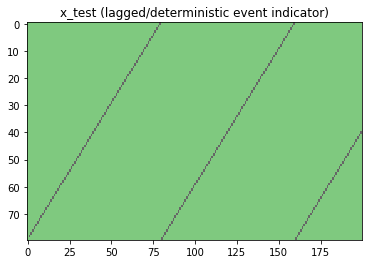

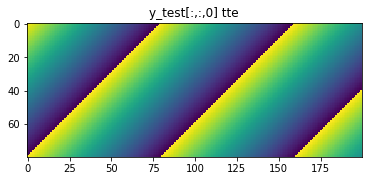

train shape (80000, 200, 2) (80000, 200, 1)


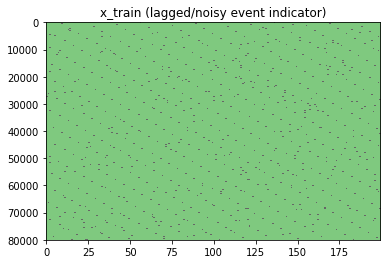

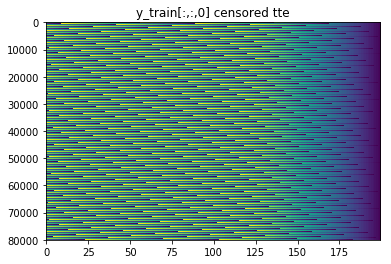

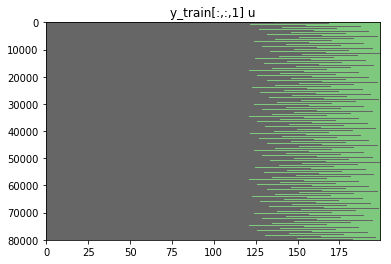

In [22]:
n_timesteps    = 200
n_sequences = every_nth = 80
n_features = 1
n_repeats = 1000
noise_level = 0.005
use_censored = True

y_train,x_train, y_test,x_test,events = get_data(n_timesteps, every_nth,n_repeats,noise_level,n_features,use_censored)

print('test shape',y_test.shape,x_test.shape)
plt.imshow(x_test[:,:,:].sum(axis=2)>0,interpolation="none",cmap='Accent',aspect='auto')
plt.title('x_test (lagged/deterministic event indicator)')
plt.show()
plt.imshow(y_test[:,:,0],interpolation="none")
plt.title('y_test[:,:,0] tte')
plt.show()

print('train shape',y_train.shape,x_train.shape)
# (might look like the pattern is different but set n_repeats 
#  lower and you'll see that it's the same):
plt.imshow(x_train[:,:,:].sum(axis=2)>0,interpolation="none",cmap='Accent',aspect='auto')
plt.title('x_train (lagged/noisy event indicator)')
plt.show()
plt.imshow(y_train[:,:,0],interpolation="none",aspect='auto')
plt.title('y_train[:,:,0] censored tte')
plt.show()
plt.imshow(y_train[:,:,1],interpolation="none",cmap='Accent',aspect='auto')
plt.title('y_train[:,:,1] u')
plt.show()

In [23]:
# Prep. output activation layer.
# Start at naive geometric (beta=1) MLE:
tte_mean_train = np.nanmean(y_train[:,:,0])
init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
init_alpha = init_alpha/np.nanmean(y_train[:,:,1]) # use if lots of censoring
print('init_alpha: ',init_alpha)

np.random.seed(1)

init_alpha:  43.44250429568219


In [24]:
from torch.autograd import Variable
from torch import nn
import torch.nn.functional as F

class WtteRnn(nn.Module):

    def __init__(self, init_alpha, max_beta_value, hidden_size,num_layers):
        super(WtteRnn, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size=n_features,hidden_size=hidden_size,num_layers=num_layers)
        self.l1 = nn.Linear(hidden_size,2)
        self.init_alpha = init_alpha
        self.max_beta_value = max_beta_value

    def forward(self, x):
        rnn_out, self.hidden = self.gru(x, self.hidden)
        
        x = F.tanh(rnn_out)
        x = self.l1(x) ## Linear activation?
        x = output_lambda(x, init_alpha = self.init_alpha, max_beta_value = self.max_beta_value)

        return x
    
    def initHidden(self,batch):
        self.hidden = Variable(torch.zeros(self.num_layers,batch,self.hidden_size).cuda())
        return self.hidden



In [25]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tnrange

wtteRnn = WtteRnn(init_alpha, 4.0, 1, 1).cuda()
print(wtteRnn)

optimizer = optim.Adam(wtteRnn.parameters(), lr = 0.01)

dataset = TensorDataset(torch.from_numpy(x_train).float().cuda(), torch.from_numpy(y_train).float().cuda())

batches = 10

dataloader = DataLoader(dataset,batch_size=x_train.shape[0]/batches,shuffle=False,num_workers=0)

x_pt_test = torch.from_numpy(x_test).float().permute(1,0,2).cuda()
y_pt_test = torch.from_numpy(y_test).float().permute(1,0,2).cuda()

t = tnrange(80)

losses = []
val_losses = []

for epoch in t:
    for i_batch, sample_batched in enumerate(dataloader):
        # TODO: Build the synthetic data permuted in the expected way
        x_batch = Variable(sample_batched[0].permute(1,0,2))
        y_batch = Variable(sample_batched[1].permute(1,0,2))
        
        # for the whole batch
        wtteRnn.zero_grad()
        loss = 0
        wtteRnn.initHidden(x_batch.shape[1])
        # the sequence for this example
        output = wtteRnn(x_batch)
        loss = weibull_loss_discrete(y_batch,output)
        loss.backward()
        optimizer.step()        
        
    wtteRnn.initHidden(x_pt_test.shape[1])
    test_output = wtteRnn(Variable(x_pt_test))
    test_loss = weibull_loss_discrete(Variable(y_pt_test), test_output)
    losses.append(loss.data[0])
    val_losses.append(test_loss.data[0])
    t.write('#{} loss {} val loss {}'.format(epoch+1, loss.data[0], test_loss.data[0]))
    

WtteRnn(
  (gru): GRU(1, 1)
  (l1): Linear(in_features=1, out_features=2, bias=True)
)


#1 loss 4.272957801818848 val loss 5.19130802154541
#2 loss 4.168945789337158 val loss 5.056648254394531
#3 loss 4.0638885498046875 val loss 4.922590732574463
#4 loss 3.9546151161193848 val loss 4.792870998382568
#5 loss 3.8519933223724365 val loss 4.680179119110107
#6 loss 3.781224012374878 val loss 4.6077423095703125
#7 loss 3.752891778945923 val loss 4.579370021820068
#8 loss 3.7444987297058105 val loss 4.566394329071045
#9 loss 3.741119384765625 val loss 4.558059215545654
#10 loss 3.7407429218292236 val loss 4.555593967437744
#11 loss 3.740440607070923 val loss 4.555335521697998
#12 loss 3.740307569503784 val loss 4.555325508117676
#13 loss 3.7401797771453857 val loss 4.554969310760498
#14 loss 3.7401208877563477 val loss 4.5548834800720215
#15 loss 3.740074396133423 val loss 4.554965019226074
#16 loss 3.740025043487549 val loss 4.554935932159424
#17 loss 3.73997163772583 val loss 4.554840564727783
#18 loss 3.739915370941162 val loss 4.554773807525635
#19 loss 3.739853858947754 val

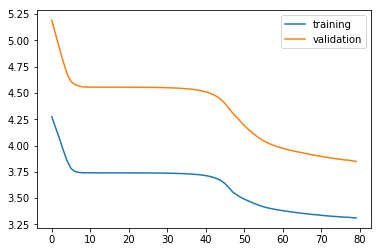

In [26]:
import matplotlib.pyplot as plt

plt.plot(losses,label='training')
plt.plot(val_losses,label='validation')
plt.legend()

# Predictions
Try out training the model with different levels of noise. With more noise confidence gets lower (smaller beta). With less noise beta goes to maximum value and the predicted mode/peak probability is centered around the actual TTE.

All test cases (no noise)
(each horizontal line is a sequence)


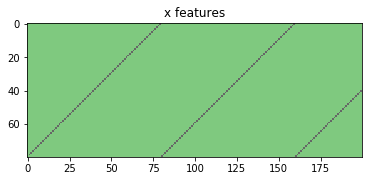

torch.Size([200, 80, 2])


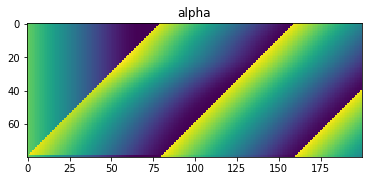

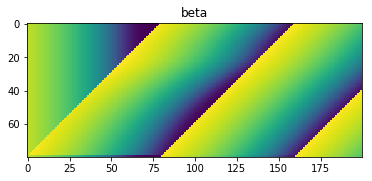

Some training cases (noisy features)
torch.Size([200, 80, 2])


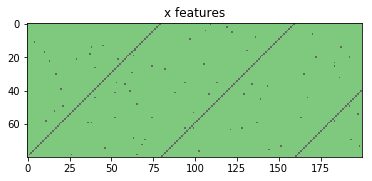

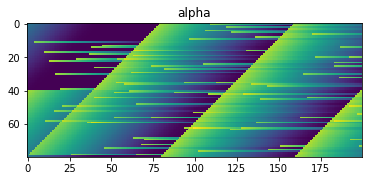

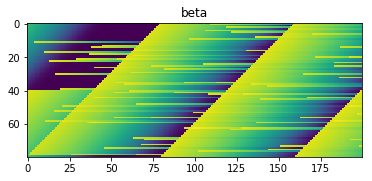

In [37]:
# Make some parametric predictions
print('All test cases (no noise)')
print('(each horizontal line is a sequence)')

x_pt_test = torch.from_numpy(x_test).float().permute(1,0,2).cuda()
y_pt_test = torch.from_numpy(y_test).float().permute(1,0,2).cuda()

wtteRnn.initHidden(x_pt_test.shape[1])
predicted = wtteRnn(Variable(x_pt_test))

plt.imshow(x_test[:every_nth,:,:].sum(axis=2)>0,interpolation="none",cmap='Accent')
plt.title('x features')
plt.show()
print(predicted.shape)
plt.imshow(predicted[:,:,0].data.permute(1,0).cpu().numpy(),interpolation="none")
plt.title('alpha')
plt.show()
plt.imshow(predicted[:,:,1].data.permute(1,0).cpu().numpy(),interpolation="none")
plt.title('beta')
plt.show()

print('Some training cases (noisy features)')
predicted = wtteRnn(Variable(torch.from_numpy(x_train[:every_nth,:,:]).float().permute(1,0,2).cuda()))
print(predicted.shape)
plt.imshow(x_train[:every_nth,:,:].sum(axis=2)>0,interpolation="none",cmap='Accent')
plt.title('x features')
plt.show()
plt.imshow(predicted[:,:,0].data.permute(1,0).cpu().numpy(),interpolation="none")
plt.title('alpha')
plt.show()
plt.imshow(predicted[:,:,1].data.permute(1,0).cpu().numpy(),interpolation="none")
plt.title('beta')
plt.show()


one training case:


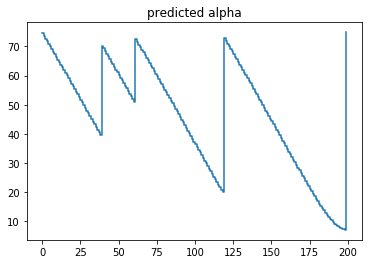

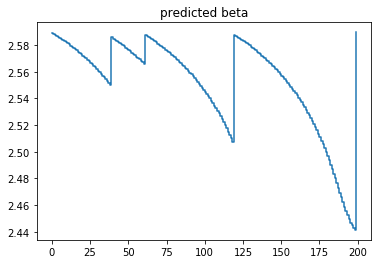

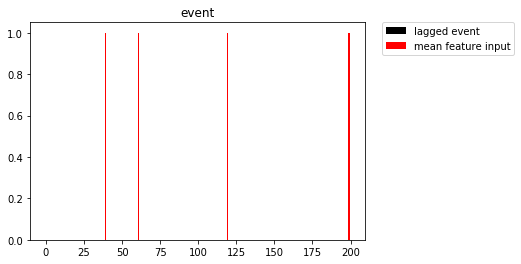

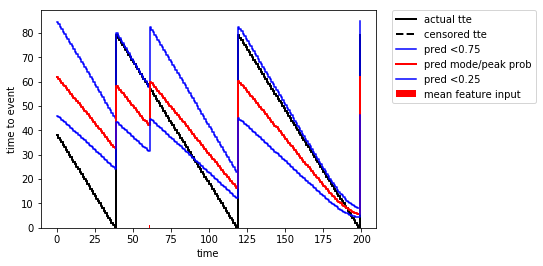

In [39]:
def weibull_quantiles(a, b, p):
    return a*np.power(-np.log(1.0-p),1.0/b)

def weibull_mode(a, b):
    # Continuous mode. 
    # TODO (mathematically) prove how close it is to discretized mode
    mode = a*np.power((b-1.0)/b,1.0/b)
    mode[b<=1.0]=0.0
    return mode

def weibull_mean(a, b):
    # Continuous mean. Theoretically at most 1 step below discretized mean 
    # E[T ] <= E[Td] + 1 true for positive distributions. 
    from scipy.special import gamma
    return a*gamma(1.0+1.0/b)

# TTE, Event Indicator, Alpha, Beta
drawstyle = 'steps-post'

print('one training case:')
batch_indx =every_nth//2
a = predicted.data.permute(1,0,2).cpu().numpy()[batch_indx,:,0]
b = predicted.data.permute(1,0,2).cpu().numpy()[batch_indx,:,1]
this_x_train = x_train[batch_indx,:,:].mean(axis=1)
this_x_test =  x_test[batch_indx,:,:].mean(axis=1)

this_tte_train = y_train[batch_indx,:,0]
this_tte_test =  y_test[batch_indx,:,0]

plt.plot(a,drawstyle='steps-post')
plt.title('predicted alpha')
plt.show()
plt.plot(b,drawstyle='steps-post')
plt.title('predicted beta')
plt.show()

plt.bar(range(n_timesteps),this_x_test,color='black', label='lagged event')
plt.bar(range(n_timesteps),this_x_train,color='red',linewidth=0,label='mean feature input')
plt.title('event')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.plot(this_tte_test ,label='actual tte',color='black',linewidth=2,drawstyle=drawstyle)
plt.plot(this_tte_train,label='censored tte',color='black',linestyle='dashed',linewidth=2,drawstyle=drawstyle)

plt.plot(weibull_quantiles(a,b,0.75),color='blue',label='pred <0.75',drawstyle=drawstyle)
plt.plot(weibull_mode(a, b), color='red',linewidth=2,label='pred mode/peak prob',drawstyle=drawstyle)
#plt.plot(weibull_mean(a, b), color='green',linewidth=1,label='pred mean',drawstyle='steps-post')
plt.plot(weibull_quantiles(a,b,0.25),color='blue',label='pred <0.25',drawstyle=drawstyle)
plt.xlabel('time')
plt.ylabel('time to event')
plt.bar(range(n_timesteps),this_x_train,color='red',label='mean feature input')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()